# Monte Carlo simulator
By: Magnus Kvåle Helliesen

# *** *Under construction* ***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from monte_carlo.monte_carlo import MonteCarlo

Suppose we have a matrix of data
$\boldsymbol{X}=(\boldsymbol{x}_0, \boldsymbol{x}_1, \ldots, \boldsymbol{x}_{N-1})$,
where
$\boldsymbol{x}_i=\{x_{i, t}\}_{t=0}^{T-1}$
is a vector representing the timeseries for some $i$ (maybe a stock ticker or something).

The aim of this notebook is to use eigen decomposition to generate $N$ independent/orthogonal disturbances, normalize these using a GARCH-model (so there is no heteroskedasticity), and draw from the resulting distributions to perform a MonteCarlo-like simulation of the input data.

The implementation is put in [`monte_carlo.py`](monte_carlo/monte_carlo.py).

# Use MonteCarlo class

In [2]:
# Function that fetches data
def fetch_data(tickers: tuple):
    data = {}
    for ticker in tickers:
        data[ticker] = yf.Ticker(ticker).history(period='max')

    # Returning transformed data
    return (
        pd.concat(data)[['Close']]
        .reset_index()
        .rename(columns={'level_0': 'Ticker'})
        .pivot(index='Date', columns='Ticker', values='Close')
    )

tickers = ('NHY.OL', 'DNB.OL', 'YAR.OL', 'NAS.OL', 'TEL.OL', 'FRO.OL')
df = fetch_data(tickers).dropna()
df

Ticker,DNB.OL,FRO.OL,NAS.OL,NHY.OL,TEL.OL,YAR.OL
Date,,,,,,
2004-03-25 00:00:00+01:00,17.060759,668.643738,1216.948120,10.964588,18.962234,22.093433
2004-03-26 00:00:00+01:00,17.216925,670.436035,1199.807983,10.977162,19.238770,22.526634
2004-03-29 00:00:00+02:00,17.255960,702.703064,1216.948120,10.914291,19.712824,21.985132
2004-03-30 00:00:00+02:00,17.177883,700.910583,1222.661499,10.826273,18.646200,21.660225
2004-03-31 00:00:00+02:00,17.568289,699.117920,1199.807983,10.863994,18.804214,21.573591
...,...,...,...,...,...,...
2023-11-09 00:00:00+01:00,200.500000,241.449997,9.840000,62.240002,115.449997,371.399994
2023-11-10 00:00:00+01:00,200.399994,238.000000,9.602000,60.520000,114.849998,364.299988
2023-11-13 00:00:00+01:00,203.199997,240.350006,9.460000,60.139999,116.500000,363.299988


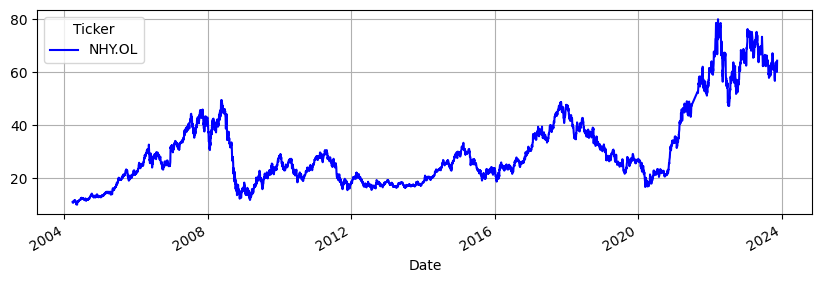

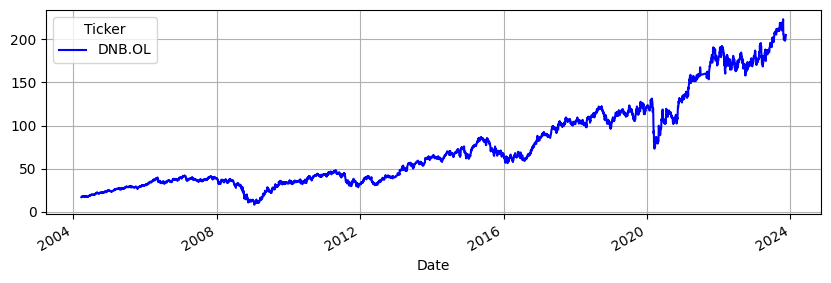

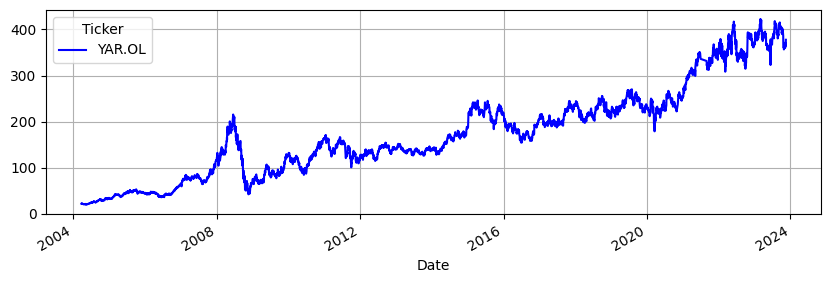

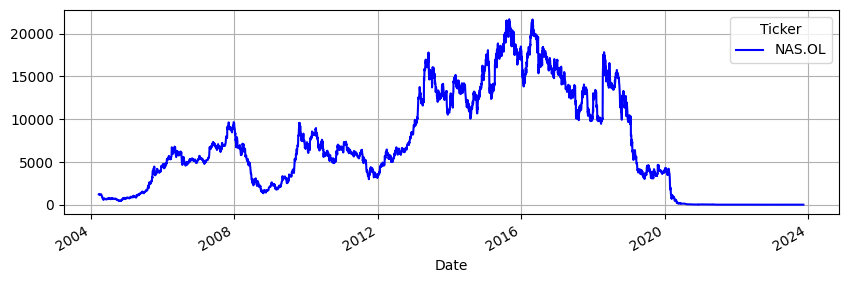

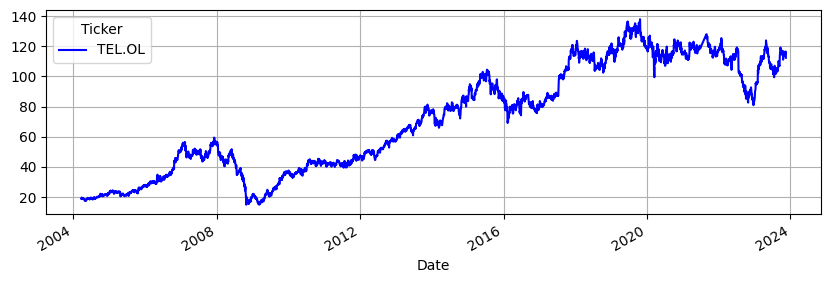

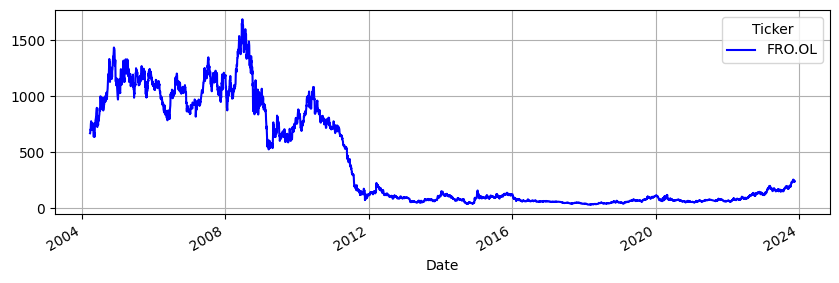

In [3]:
for ticker in tickers:
    df[[ticker]].plot(color='b', figsize=(10, 3), grid=True)

In [4]:
# Calculating log-differences and removing first value
df_diff = np.log(df).diff().iloc[1:, :]
df_diff

Ticker,DNB.OL,FRO.OL,NAS.OL,NHY.OL,TEL.OL,YAR.OL
Date,,,,,,
2004-03-26 00:00:00+01:00,0.009112,0.002677,-0.014185,0.001146,0.014478,0.019418
2004-03-29 00:00:00+02:00,0.002265,0.047006,0.014185,-0.005744,0.024342,-0.024332
2004-03-30 00:00:00+02:00,-0.004535,-0.002554,0.004684,-0.008097,-0.055627,-0.014889
2004-03-31 00:00:00+02:00,0.022473,-0.002561,-0.018869,0.003478,0.008439,-0.004008
2004-04-01 00:00:00+02:00,-0.011173,0.042667,-0.014389,-0.005804,-0.004210,0.004008
...,...,...,...,...,...,...
2023-11-09 00:00:00+01:00,0.007761,0.008527,0.014330,-0.002247,0.007390,0.006754
2023-11-10 00:00:00+01:00,-0.000499,-0.014392,-0.024484,-0.028024,-0.005211,-0.019302
2023-11-13 00:00:00+01:00,0.013875,0.009826,-0.014899,-0.006299,0.014264,-0.002749


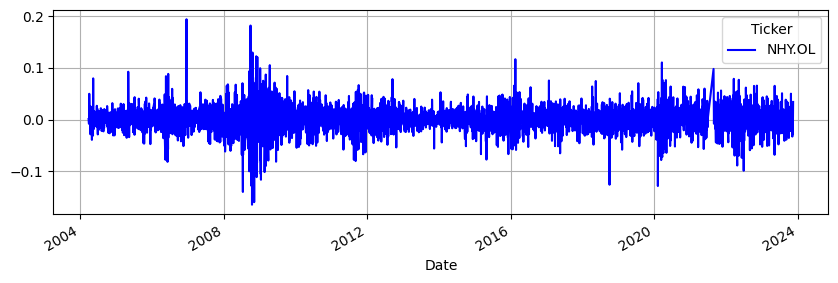

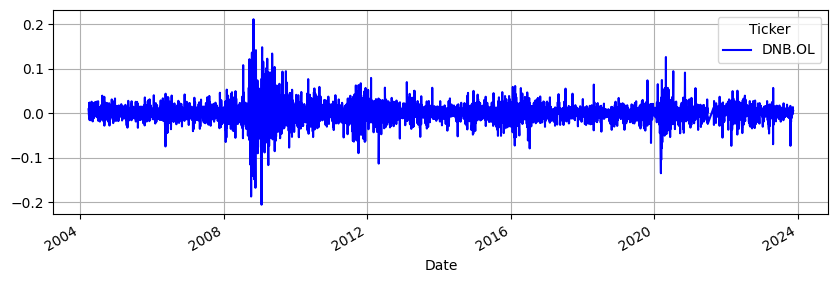

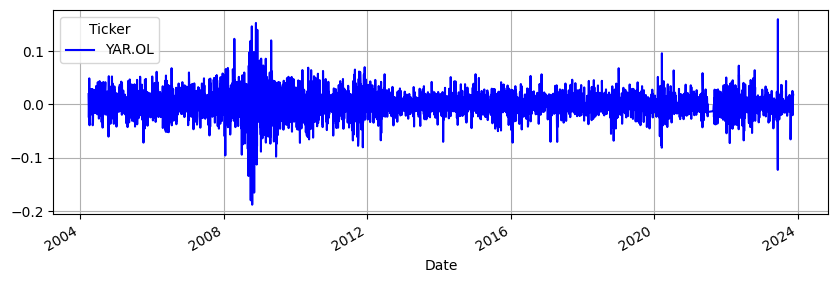

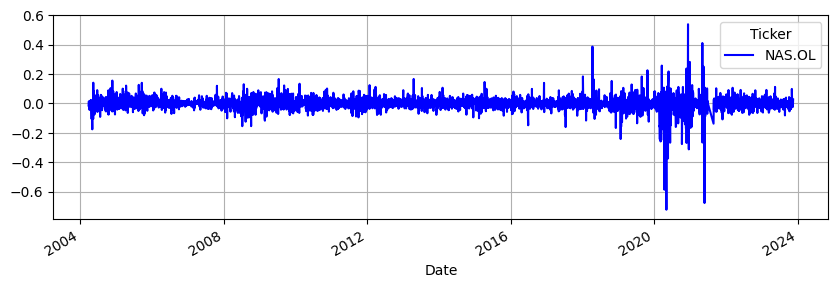

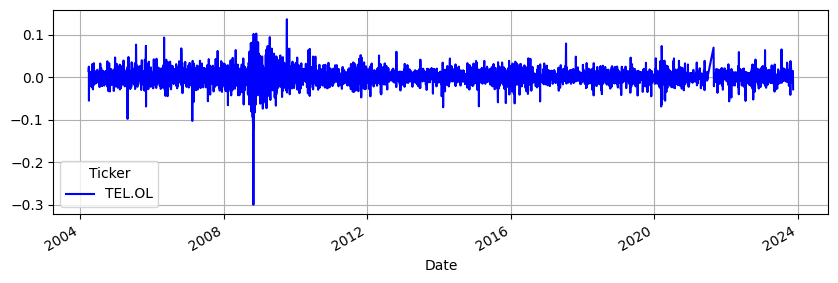

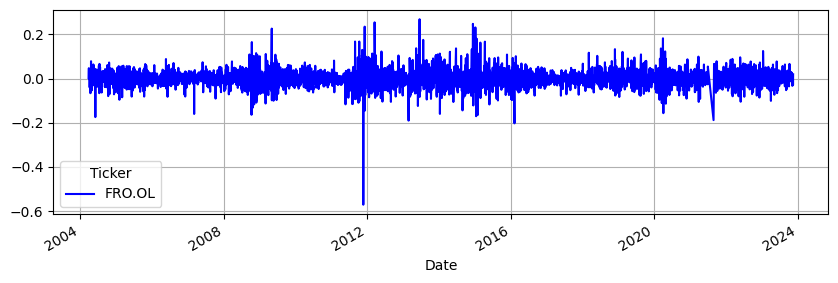

In [5]:
for ticker in tickers:
    df_diff[[ticker]].plot(color='b', figsize=(10, 3), grid=True)

In [6]:
df_diff.corr().style.background_gradient(cmap='Blues')

Ticker,DNB.OL,FRO.OL,NAS.OL,NHY.OL,TEL.OL,YAR.OL
Ticker,,,,,,
DNB.OL,1.000000,0.253368,0.194700,0.482028,0.388387,0.418089
FRO.OL,0.253368,1.000000,0.124599,0.315521,0.196898,0.277698
NAS.OL,0.194700,0.124599,1.000000,0.203254,0.152532,0.167728
NHY.OL,0.482028,0.315521,0.203254,1.000000,0.352222,0.488102
TEL.OL,0.388387,0.196898,0.152532,0.352222,1.000000,0.346098
YAR.OL,0.418089,0.277698,0.167728,0.488102,0.346098,1.000000


In [7]:
model = MonteCarlo(df_diff)
fit = model.fit()

# Okay, the disturbances are orthogonal. This we can work with
fit.orthog_disturbances_df.cov().style.background_gradient(cmap='Blues')

,0,1,2,3,4,5
0,1.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000
1,-0.000000,1.000000,-0.000000,-0.000000,0.000000,-0.000000
2,-0.000000,-0.000000,1.000000,0.000000,0.000000,-0.000000
3,-0.000000,-0.000000,0.000000,1.000000,-0.000000,0.000000
4,0.000000,0.000000,0.000000,-0.000000,1.000000,0.000000
5,-0.000000,-0.000000,-0.000000,0.000000,0.000000,1.000000


In [8]:
# The normalized ones are nearly orthogonal too
fit.norm_orthog_disturbances_df.cov().style.background_gradient(cmap='Blues')

,0,1,2,3,4,5
0,0.999474,0.086491,0.034025,0.022656,0.013743,-0.014881
1,0.086491,1.000330,0.050624,0.014706,0.002927,-0.018494
2,0.034025,0.050624,1.000173,-0.019153,-0.039405,0.049578
3,0.022656,0.014706,-0.019153,1.000850,-0.032137,0.008647
4,0.013743,0.002927,-0.039405,-0.032137,1.000501,0.064911
5,-0.014881,-0.018494,0.049578,0.008647,0.064911,1.000758


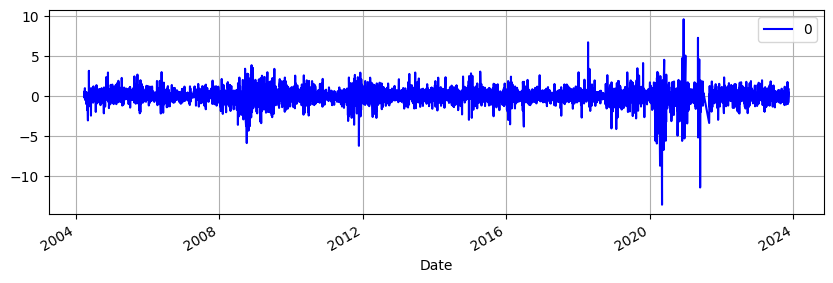

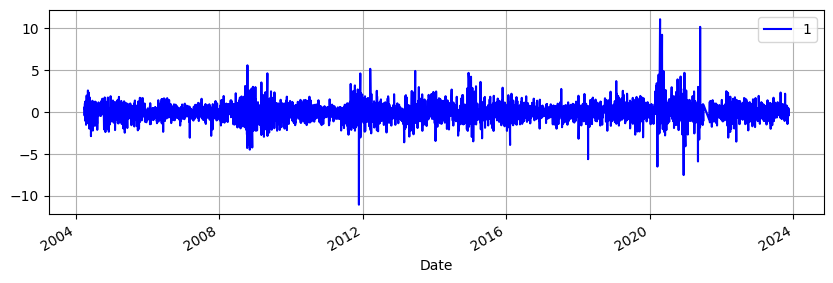

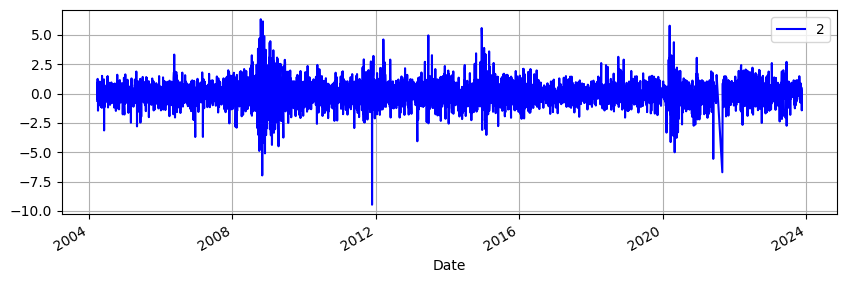

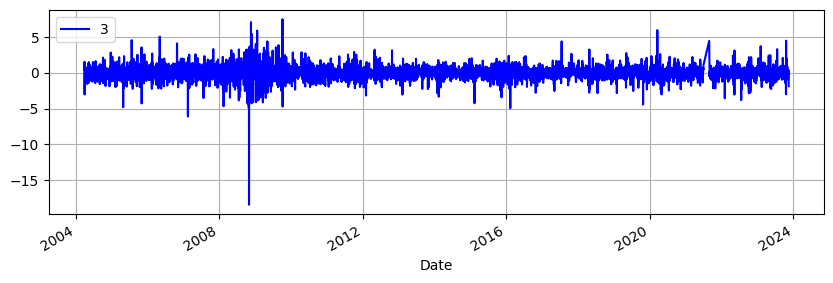

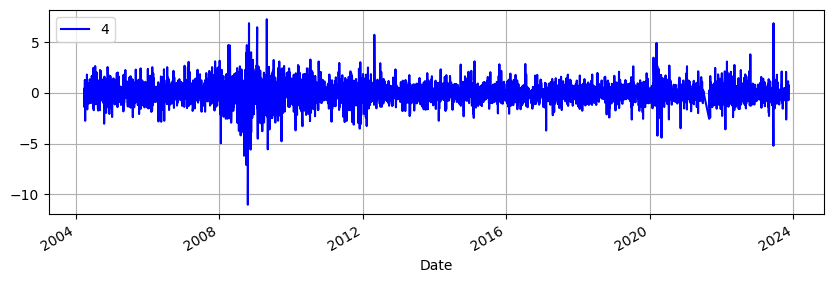

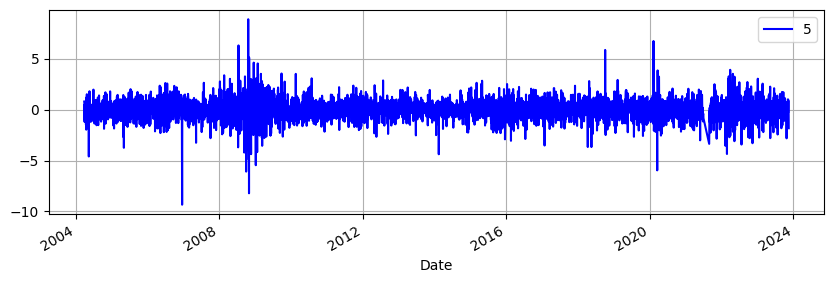

In [9]:
# Orthogonal disturbances
for col in fit.orthog_disturbances_df.columns:
    fit.orthog_disturbances_df[[col]].plot(color='b', figsize=(10, 3), grid=True)

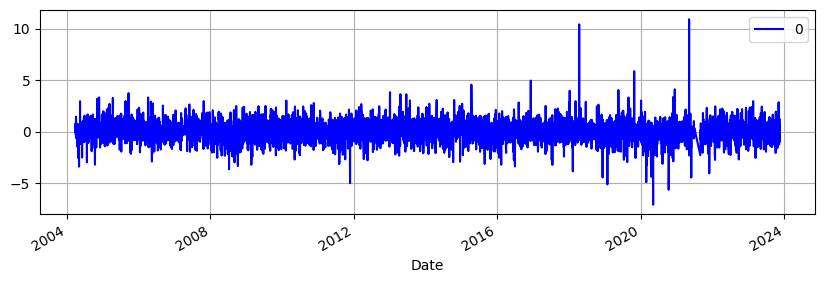

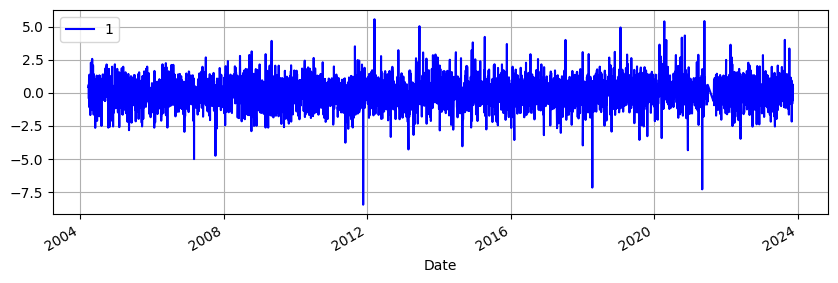

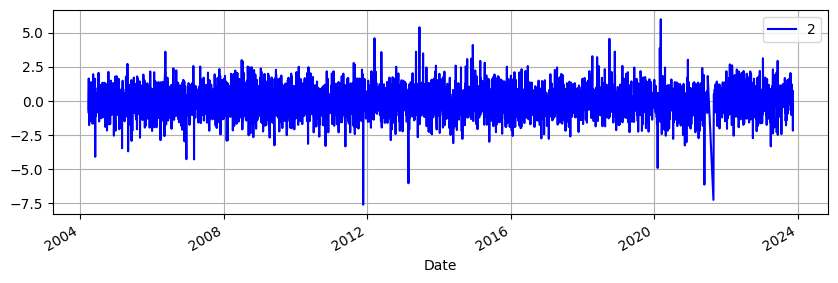

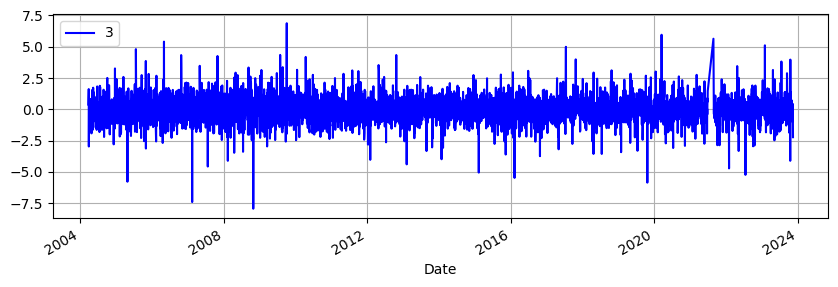

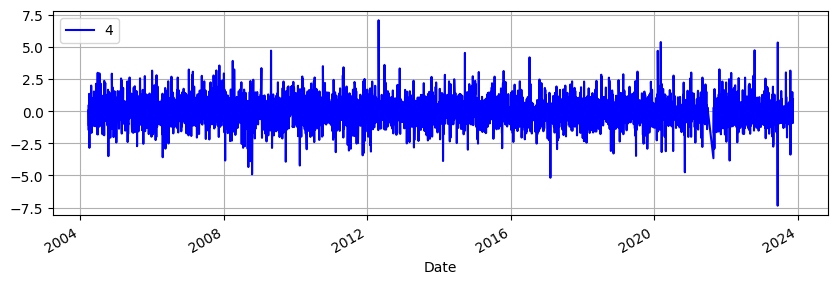

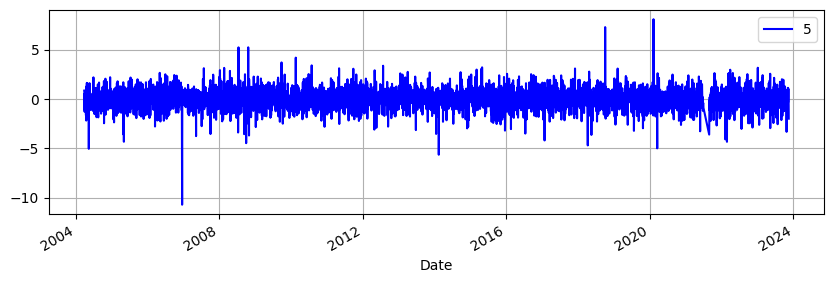

In [10]:
# Orthognal disturbances where heteroskedasticity is removed using GARCH model fits
for col in fit.orthog_disturbances_df.columns:
    fit.norm_orthog_disturbances_df[[col]].plot(color='b', figsize=(10, 3), grid=True)

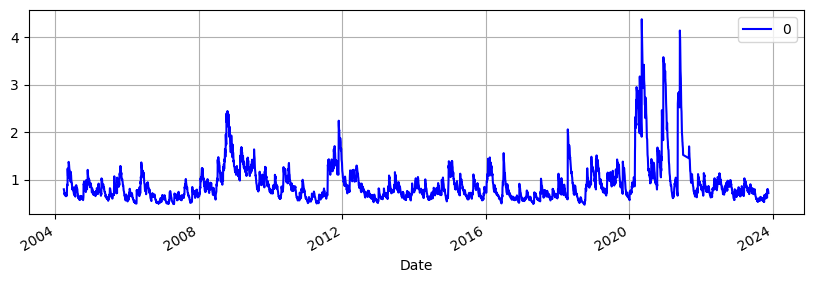

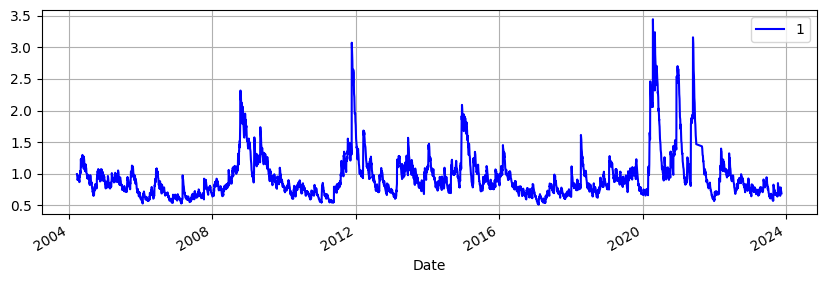

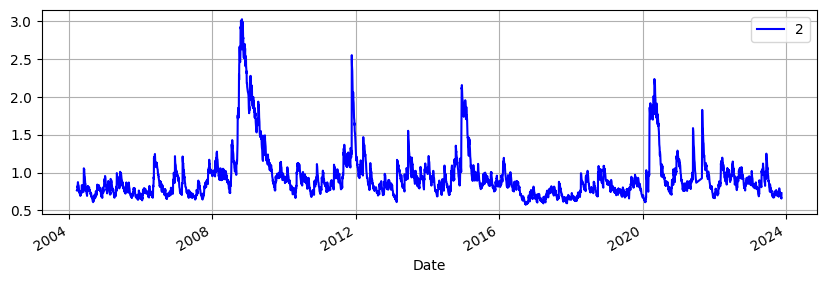

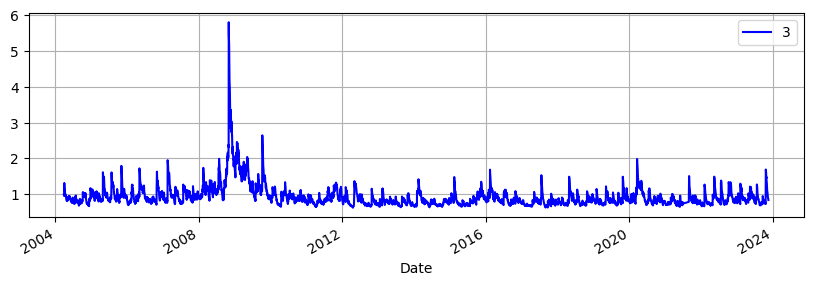

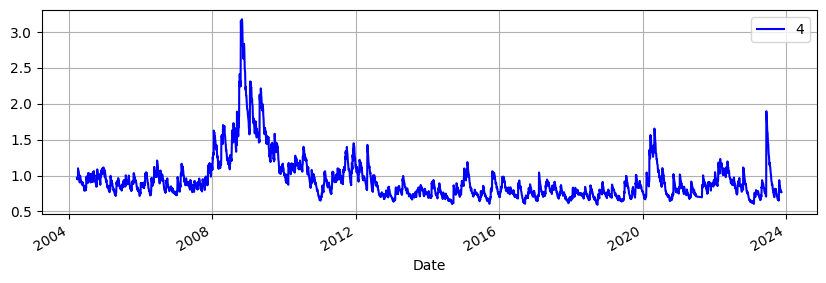

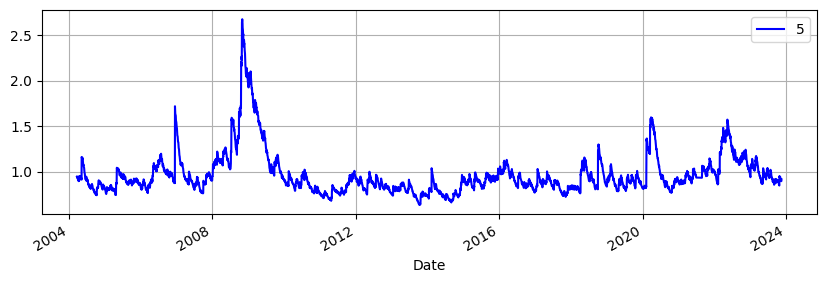

In [11]:
# Look at GARCH-estimated volatility
for col in fit.conditional_volatility_df.columns:
    fit.conditional_volatility_df[[col]].plot(color='b', figsize=(10, 3), grid=True)

In [12]:
n_periods = 100
n_simulations = 100

# Store forecast in dict
forecast = fit.forecast(n_periods, n_simulations)

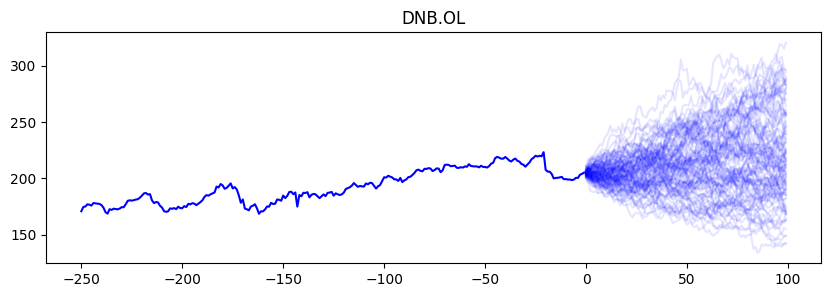

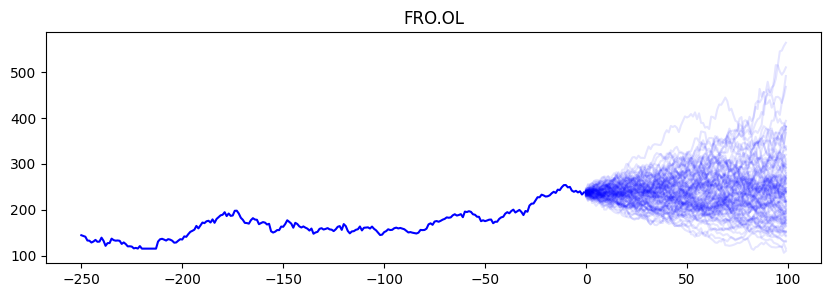

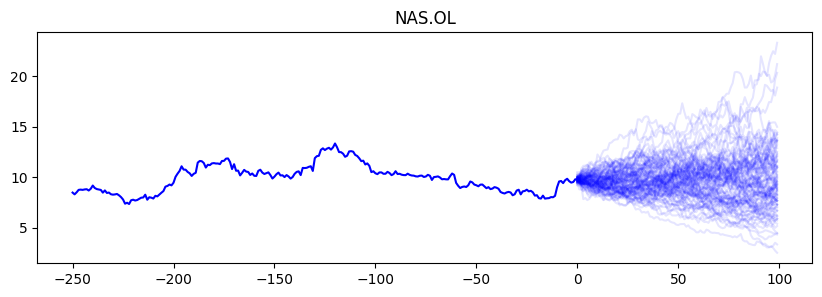

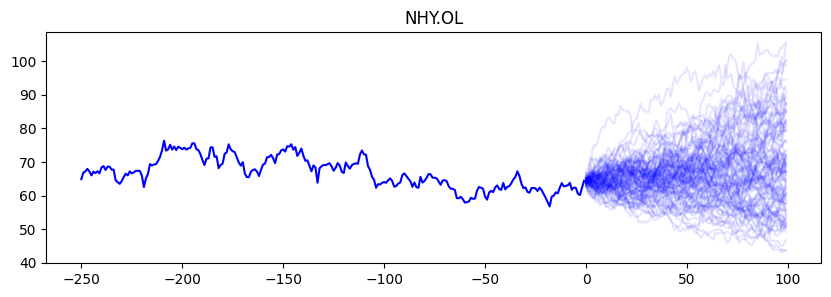

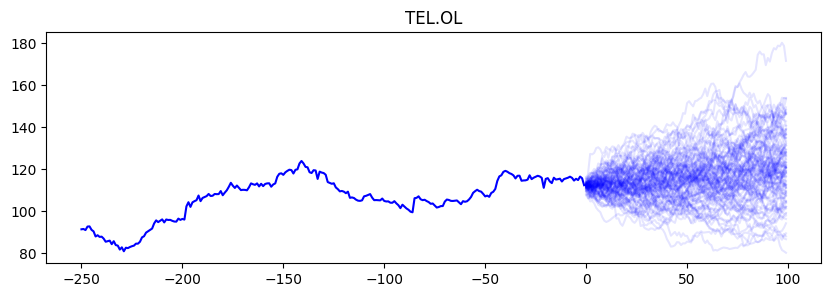

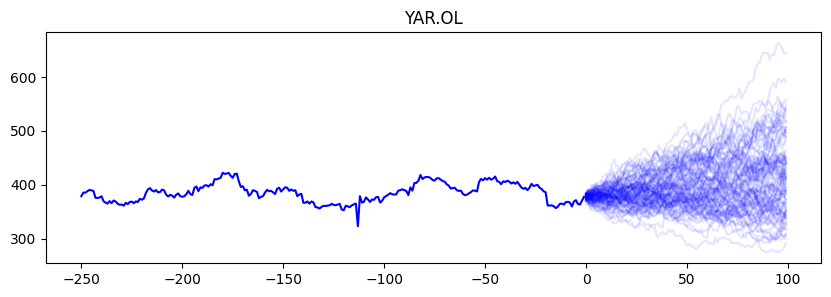

In [38]:
# Make a new df with index that runs to -1 to allow for plot of simulation from 0
df_range_index = df
df_range_index.index = range(-df_range_index.shape[0], 0)

# Look at some forecast around 0
for col in df.columns:
    plt.figure()
    for i in range(n_simulations):
        (df[col].iloc[-1]*np.exp(forecast.get(i)[col].cumsum())).plot(color = 'b', alpha=0.1, figsize=(10, 3), grid=True, title=col)
    df_range_index.loc[-250:, col].plot(color = 'b')
    plt.show()